In [5]:
import numpy as np
import scipy as sp
from scipy import io,integrate,sparse
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Rectangle,Circle

from scipy.stats import chi2
from scipy.io import loadmat
import time

from lanczos_bin import *
#from lanczos_bin import mystep,distribution

from IPython.display import clear_output
np.set_printoptions(linewidth=300)
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
plt.rcParams['text.latex.preamble'] = r'\renewcommand{\vec}{\mathbf}'
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

In [7]:
# Estrada index on Roget graph
P = loadmat('rog.mat')
A = P['A']
B = A.toarray()
λ = np.linalg.eigh(B)[0]

delta = 0.05
b = 2
n = 30
f = lambda x : np.exp(x)
texact = sum(f(λ))
print(texact)

2.3799770208989445e+05


In [42]:
ntrials = 100
ps =  range(2,8)
KRY = np.zeros((4,ntrials*len(ps)))
HPP = np.zeros((4,ntrials*len(ps)))

k = 0
np.random.seed(0)
for (i,p) in enumerate(ps):
    for j in range(ntrials):
        print(f'{i}: trial {j}')
        clear_output(wait=True)
        
        epsilon = abs(texact) * 2**(-p)
        t, c, r = ada_krylov(A,f,b,n,epsilon,delta)
        KRY[0,k] = abs(t-texact)/abs(texact)
        KRY[1,k] = c+r
        KRY[2,k] = c
        KRY[3,k] = r
        
        t, c, r = ada_hpp(A,f,n,epsilon,delta)
        HPP[0,k] = abs(t-texact)/abs(texact)
        HPP[1,k] = c+r
        HPP[2,k] = c
        HPP[3,k] = r
        
        k = k + 1

5: trial 99


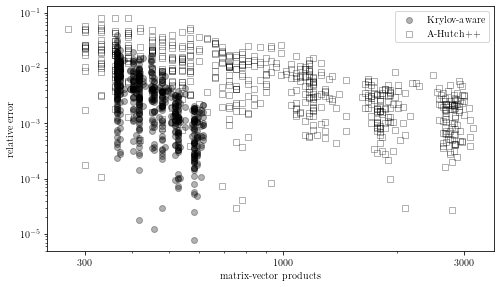

In [50]:
fig,axs = plt.subplots(1,1,figsize=(8,4.5))
axs = [axs]


axs[0].scatter(KRY[1,:],abs(KRY[0,:]),alpha=.3,c='black',label='Krylov-aware')
axs[0].scatter(HPP[1,:],abs(HPP[0,:]),alpha=.3,c='none',marker="s",edgecolors='black',label='A-Hutch++')


axs[0].set_yscale('log')
axs[0].set_xscale('log')
axs[0].set_xticks([300,1000,3000])
axs[0].set_xticklabels([300,1000,3000])

plt.xlabel("matrix-vector products")
plt.ylabel("relative error")

plt.legend()

plt.savefig('imgs/roget-estrada.pdf')

In [45]:
lp = len(ps)

Kdfl = np.reshape(KRY[2,:],(lp,ntrials))
Krem = np.reshape(KRY[3,:],(lp,ntrials))
Kmd  = np.mean(Kdfl,axis=1)
Kmr  = np.mean(Krem,axis=1)

Hdfl = np.reshape(HPP[2,:],(lp,ntrials))
Hrem = np.reshape(HPP[3,:],(lp,ntrials))
Hmd  = np.mean(Hdfl,axis=1)
Hmr  = np.mean(Hrem,axis=1)

dat = np.zeros((lp,11))
dat[:,0] = np.array(ps)[:lp]
dat[:,1] = Kmd - (n-1)*b
dat[:,2] = Kmr/n
dat[:,3] = Kmd
dat[:,4] = Kmr
dat[:,5] = Kmd+Kmr
dat[:,6] = Hmd/(2*n)
dat[:,7] = Hmr/n
dat[:,8] = Hmd
dat[:,9] = Hmr
dat[:,10] = Hmd+Hmr

np.set_printoptions(precision=4)
np.set_printoptions(linewidth=160)
np.set_printoptions(suppress=True)
print(np.round(dat))


[[   2.   72.    2.  304.   60.  364.    3.    5.  208.  160.  368.]
 [   3.   80.    2.  312.   74.  386.    5.    8.  278.  253.  531.]
 [   4.   96.    3.  328.   93.  421.    6.   14.  390.  408.  798.]
 [   5.  130.    4.  362.  106.  469.   10.   20.  609.  586. 1195.]
 [   6.  174.    4.  406.  118.  524.   15.   31.  916.  936. 1851.]
 [   7.  233.    4.  465.  125.  590.   24.   45. 1445. 1354. 2799.]]


In [16]:
ntrials = 100

bs = [1,4,8]

ps =  range(2,8)
KRY = np.zeros((4,ntrials*len(ps)))
HPP = np.zeros((4,ntrials*len(ps)))

dat_bs = np.zeros((len(ps),3*len(bs)+1))
errs = np.zeros((len(ps)*ntrials,len(bs)))
costs = np.zeros((len(ps)*ntrials,len(bs)))
times = np.zeros((len(ps), len(bs)+1))

np.random.seed(0)
for (i,p) in enumerate(ps):
    dat_bs[i,0] = p
    for j in range(ntrials):
        print(f'{i}: trial {j}')
        clear_output(wait=True)
        
        for (l,b) in enumerate(bs):
            epsilon = abs(texact) * 2**(-p)
            
            start = time.time()
            t, c, r = ada_krylov(A,f,b,n,epsilon,delta)
            end = time.time()
            
            errs[i*ntrials+j,l] += abs(t-texact)/abs(texact)
            costs[i*ntrials+j,l] += c+r
            
            dat_bs[i,3*l+1] += (c - (n-1)*b)/ntrials
            dat_bs[i,3*l+2] += (r/n)/ntrials
            dat_bs[i,3*l+3] += (c+r)/ntrials
            
            times[i,l] += (end-start)/ntrials
            
            
        start = time.time()
        t, c, r = ada_hpp(A,f,n,epsilon,delta)
        end = time.time()
        
        times[i,-1] += (end-start)/ntrials

5: trial 99


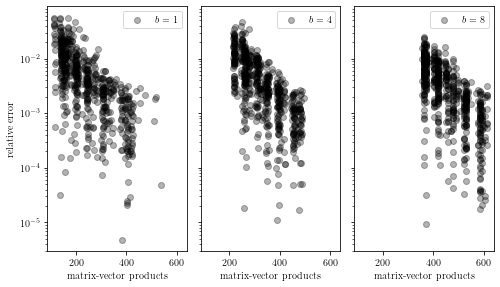

In [52]:
fig,axs = plt.subplots(1,3,figsize=(8,4.5),sharex=True,sharey=True)
plt.subplots_adjust(wspace=.1)

axs[0].scatter(costs[:,0],abs(errs[:,0]),alpha=.3,c='black',label=f'$b={bs[0]}$')
axs[1].scatter(costs[:,1],abs(errs[:,1]),alpha=.3,c='black',label=f'$b={bs[1]}$')
axs[2].scatter(costs[:,2],abs(errs[:,2]),alpha=.3,c='black',label=f'$b={bs[2]}$')


axs[0].set_yscale('log')
#axs[0].set_xscale('log')

for i in range(3):
    axs[i].set_xlabel("matrix-vector products")
    axs[i].legend()#text(.75,.95,f'$b={bs[i]}$', ha='left', va='top', transform=axs[i].transAxes)

axs[0].set_ylabel("relative error")


plt.savefig('imgs/roget-blocks2.pdf')

In [49]:
np.set_printoptions(linewidth=160)
np.set_printoptions(suppress=True)
print(np.round(dat_bs).astype('int'))

[[  2  23   3 140  44   2 230  72   2 364]
 [  3  36   3 163  56   3 261  81   2 386]
 [  4  51   4 202  73   4 298  96   3 421]
 [  5  92   4 253 113   4 342 130   4 469]
 [  6 124   5 316 157   4 398 174   4 523]
 [  7 160   7 408 216   4 465 233   4 589]]
